# Segmentación por uso de la App de Vodafone

In [1]:
from common.src.main.python.utils.hdfs_generic import *
import os
import pyspark.sql.functions as f
from pyspark.sql.functions import to_timestamp, current_timestamp
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType


MAX_N_EXECUTORS=35
MIN_N_EXECUTORS=20
N_CORES_EXECUTOR=8
EXECUTOR_IDLE_MAX_TIME=120
EXECUTOR_MEMORY='32g'
DRIVER_MEMORY='16g'
N_CORES_DRIVER=1
MEMORY_OVERHEAD=N_CORES_EXECUTOR*2048
#QUEUE="root.datascience.normal"
QUEUE="root.BDPtenants.es.medium"

BDA_CORE_VERSION="1.0.0"

SPARK_COMMON_OPTS=os.environ.get('SPARK_COMMON_OPTS', '')
SPARK_COMMON_OPTS+=" --executor-memory %s --driver-memory %s" % (EXECUTOR_MEMORY, DRIVER_MEMORY)
SPARK_COMMON_OPTS+=" --conf spark.shuffle.manager=tungsten-sort"
SPARK_COMMON_OPTS+="  --queue %s" % QUEUE
APP_NAME='COVID_self_isolation'

# Dynamic allocation configuration
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.enabled=true"
SPARK_COMMON_OPTS+=" --conf spark.shuffle.service.enabled=true"
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.maxExecutors=%s" % (MAX_N_EXECUTORS)
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.minExecutors=%s" % (MIN_N_EXECUTORS)
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.executorIdleTimeout=%s" % (EXECUTOR_IDLE_MAX_TIME)
SPARK_COMMON_OPTS+=" --conf spark.ui.port=58201"
SPARK_COMMON_OPTS+=" --conf spark.port.maxRetries=200"
SPARK_COMMON_OPTS+=" --executor-cores=%s" % (N_CORES_EXECUTOR)
SPARK_COMMON_OPTS+=" --conf spark.app.name=%s" % (APP_NAME)

BDA_ENV = os.environ.get('BDA_USER_HOME', '')

# Attach bda-core-ra codebase
SPARK_COMMON_OPTS+=" --files \
{}/scripts/properties/red_agent/nodes.properties,\
{}/scripts/properties/red_agent/nodes-de.properties,\
{}/scripts/properties/red_agent/nodes-es.properties,\
{}/scripts/properties/red_agent/nodes-ie.properties,\
{}/scripts/properties/red_agent/nodes-it.properties,\
{}/scripts/properties/red_agent/nodes-pt.properties,\
{}/scripts/properties/red_agent/nodes-uk.properties".format(*[BDA_ENV]*7)

os.environ["SPARK_COMMON_OPTS"] = SPARK_COMMON_OPTS
os.environ["PYSPARK_SUBMIT_ARGS"] = "%s pyspark-shell " % SPARK_COMMON_OPTS

#print os.environ.get('SPARK_COMMON_OPTS', '')
#print os.environ.get('PYSPARK_SUBMIT_ARGS', '')

sc, spark, sqlContext = run_sc()
print sc.defaultParallelism

8


In [2]:
def set_paths():
    import os
    import sys

    USECASES_SRC = os.path.join(os.environ.get('BDA_USER_HOME', ''), "repositorios", "use-cases")
    if USECASES_SRC not in sys.path:
        sys.path.append(USECASES_SRC)

In [3]:
set_paths()

from churn_nrt.src.utils.spark_session import get_spark_session

In [3]:
sc, spark, sql_context = get_spark_session(app_name="app_myvf_segmentation")

**Tabla apps: raw_es.customerprofilecar_adobe_sections**

**Módulo (funciones) para obtener los atributos de app entre dos fechas a y b: use-cases/churn_nrt/src/data/myvf_data.py**

Para los clientes que estaban en compañía el 1 de julio de 2019 y siguen con nosotros a día de hoy, aplicando los filtros, nos interesa ver qué perfiles de uso hay:

- Por un lado, tendremos los que no aparecen en esa tabla nunca: no usuario

- Para el resto, podemos ver cómo es el histograma de las variables más representativas del uso: días desde el último acceso (la que ellos usan); número total de accesos; días en los que se ha accedido desde ese 1 de julio; tiempo total en app (si lo estamos extrayendo)


Obtenemos histograma; si tenemos suerte, podemos ver picos en el histograma que identificaran a cada uno de los segmentos. Si no, decidimos las fronteras directamentecomo han hecho los de digital

In [5]:
from churn_nrt.src.data.myvf_data import *

In [8]:
df_myvf = MyVFdata(spark, platform='app', version=2).get_module('20200701', save_others=False, force_gen=False)

[DataTemplate] __init__ | module name = myvf/app/2 | path = /data/udf/vf_es/churn_nrt/myvf/app/2 | verbose = True
[DataTemplate] get_module | module myvf/app/2 - for closing_day=20200701 save=True save_others=False force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/myvf/app/2/year=2020/month=7/day=1'


**Clientes que en 2019 llevaban 3 meses en la compañía**

In [9]:
from churn_nrt.src.data_utils.base_filters import get_non_recent_customers_filter

df_recientes_julio = get_non_recent_customers_filter(spark, '20190701', 90, level='msisdn')

[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] get_module | module customer_base - for closing_day=20190701 save=False save_others=False force_gen=False
[DataTemplate] get_module | args: () | kwargs: {'add_tgs': False}
[CustomerBase] is_default_module | args: () | kwargs: {'add_tgs': False}
[DataTemplate] get_module | Not found a module - '/data/udf/vf_es/churn_nrt/customer_base/year=2019/month=7/day=1'. Starting generation...
[CustomerBase] build_module | closing_day=20190701 force_gen=False add_tgs=False level=nif_cliente
[CustomerBase] Get get_customer_base_segment base segment | date 20190701 save_others False level=NIF_CLIENTE
[CustomerBase] __get_customer_base date_=20190701 save_others=False add_columns_customer=None
[DataTemplate] __init__ | module name = customer | path = /data/udf/vf_es/churn_nrt/customer | verbose = True
[DataTemplate] get_module | module customer - for closing_day=201907

**Cartera actual: 1 de julio de 2020 (clientes móviles activos)**

In [10]:
from churn_nrt.src.data.customer_base import CustomerBase

current_base_df = CustomerBase(spark).get_module('20200701', save=False, save_others=False, add_tgs=False).filter(col("rgu") == "mobile").select('msisdn').distinct()

[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] get_module | module customer_base - for closing_day=20200701 save=False save_others=False force_gen=False
[DataTemplate] get_module | args: () | kwargs: {'add_tgs': False}
[CustomerBase] is_default_module | args: () | kwargs: {'add_tgs': False}
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/customer_base/year=2020/month=7/day=1'


In [11]:
from churn_nrt.src.data_utils.base_filters import keep_active_services

current_base_df = keep_active_services(current_base_df)

**Clientes actuales que estaban en la cartera de julio de 2019**

In [12]:
final_base = current_base_df.join(df_recientes_julio, ['msisdn'], 'inner').select('msisdn').distinct()

In [10]:
final_base.count()

4641988

## Clientes que están en la base pero no aparecen en la tabla de la app: no usuarios

In [11]:
#in churn but not in new afin base

from pyspark.sql.functions import isnull, lit, col, when
no_users=final_base.join(df_myvf.withColumn('tmp',lit(1)),
                               ['msisdn'],'left').filter(isnull(col('tmp'))).select('msisdn')

In [13]:
no_users.count()

2209915

In [14]:
no_users.limit(5).toPandas()

,msisdn,myvf_nb_pages_last7,myvf_nb_pages_last14,myvf_nb_pages_last30,myvf_nb_pages_last60,myvf_nb_pages_last90,myvf_nb_pages_last120,myvf_nb_pages_last240,myvf_nb_pages_last365,myvf_nb_days_access_last7,...,myvf_webview_1st_navig_last365_nif,myvf_webview_last_navig_last7_nif,myvf_webview_last_navig_last14_nif,myvf_webview_last_navig_last30_nif,myvf_webview_last_navig_last60_nif,myvf_webview_last_navig_last90_nif,myvf_webview_last_navig_last120_nif,myvf_webview_last_navig_last240_nif,myvf_webview_last_navig_last365_nif,tmp
0,600005109,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,600012037,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,600015412,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,600033953,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,600037345,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


## Clientes que sí aparecen en la tabla de la app

In [13]:
app_users=final_base.join(df_myvf, ['msisdn'],'inner')

In [37]:
app_users.printSchema()

root
 |-- msisdn: string (nullable = true)
 |-- myvf_nb_pages_last151: long (nullable = false)
 |-- myvf_nb_pages_last365: long (nullable = false)
 |-- myvf_nb_days_access_last151: long (nullable = false)
 |-- myvf_nb_days_access_last365: long (nullable = false)
 |-- myvf_permanencia_nb_pages_last151: long (nullable = true)
 |-- myvf_permanencia_nb_pages_last365: long (nullable = true)
 |-- myvf_avg_days_bw_navigations_last151: double (nullable = false)
 |-- myvf_avg_days_bw_navigations_last365: double (nullable = false)
 |-- myvf_1st_navig_last151: integer (nullable = true)
 |-- myvf_1st_navig_last365: integer (nullable = true)
 |-- myvf_last_navig_last151: integer (nullable = true)
 |-- myvf_last_navig_last365: integer (nullable = true)
 |-- myvf_permanencia_1st_navig_last151: integer (nullable = true)
 |-- myvf_permanencia_1st_navig_last365: integer (nullable = true)
 |-- myvf_permanencia_last_navig_last151: integer (nullable = true)
 |-- myvf_permanencia_last_navig_last365: integer

In [16]:
app_users.count()

2432071

## Segmentación 1: días que lleva sin acceder a la app en el último año

In [68]:
app_users_1=app_users.filter(col('myvf_last_navig_last365')!=-1)

In [82]:
# Doing the heavy lifting in Spark. We could leverage the `histogram` function from the RDD api

gre_histogram = app_users_1.select('myvf_last_navig_last365').rdd.flatMap(lambda x: x).histogram(50)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*gre_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

KeyboardInterrupt: 

## Segmentación 2: veces que ha accedido a la app

In [ ]:
# Doing the heavy lifting in Spark. We could leverage the `histogram` function from the RDD api

gre_histogram2 = app_users.select('myvf_nb_days_access_last365').rdd.flatMap(lambda x: x).histogram(20)

In [84]:
gre_histogram2 

([0.0,
  18.15,
  36.3,
  54.449999999999996,
  72.6,
  90.75,
  108.89999999999999,
  127.04999999999998,
  145.2,
  163.35,
  181.5,
  199.64999999999998,
  217.79999999999998,
  235.95,
  254.09999999999997,
  272.25,
  290.4,
  308.54999999999995,
  326.7,
  344.84999999999997,
  363],
 [1779985,
  359040,
  143578,
  66362,
  34292,
  18483,
  11272,
  6530,
  4189,
  2655,
  1829,
  1204,
  803,
  613,
  422,
  319,
  202,
  137,
  84,
  78])

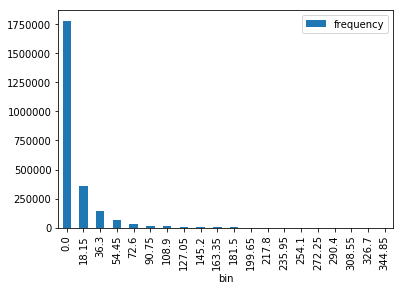

In [77]:
# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*gre_histogram2)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

estaba pensándolo, tal vez fijándome en esa variable vería 3 segmentos: los que han accedido menos de 3 veces (usuario que conoce la app pero no entra apenas, que son unos 900.000), los que han accedido entre 4 y 

Me fijo en los de <=54.45

In [83]:
app_users_2_1=app_users.filter(col('myvf_nb_days_access_last365')<=54.45)

gre_histogram2_1 = app_users_2_1.select('myvf_nb_days_access_last365').rdd.flatMap(lambda x: x).histogram(50)

KeyboardInterrupt: 

In [85]:
gre_histogram2_1

([0.0,
  2.7,
  5.4,
  8.100000000000001,
  10.8,
  13.5,
  16.200000000000003,
  18.900000000000002,
  21.6,
  24.3,
  27.0,
  29.700000000000003,
  32.400000000000006,
  35.1,
  37.800000000000004,
  40.5,
  43.2,
  45.900000000000006,
  48.6,
  51.300000000000004,
  54],
 [587337,
  424655,
  271839,
  136650,
  162359,
  126902,
  70242,
  88926,
  73313,
  42071,
  55582,
  47085,
  40089,
  23437,
  31416,
  27319,
  15942,
  21701,
  19206,
  16530])

In [ ]:
# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*gre_histogram2_1)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

## Segmentación 3: días desde primera navegación

In [75]:
app_users_3=app_users.filter(col('myvf_1st_navig_last365')!=-1)

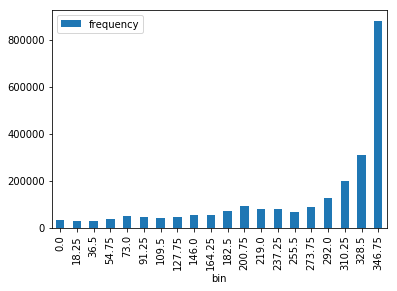

In [76]:
# Doing the heavy lifting in Spark. We could leverage the `histogram` function from the RDD api

gre_histogram3 = app_users_3.select('myvf_1st_navig_last365').rdd.flatMap(lambda x: x).histogram(20)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*gre_histogram3)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

# SEGMENTACIÓN 2

# Nos quedamos con los que entraron alguna vez entre el 1 de julio de 2019 y el 1 de febrero de 2020 y analizamos el uso de estos entre el 1 de febrero de 2020 y el 1 de julio de 2020

**Días que hay entre 1 febrero de 2020 y 1 julio de 2019**

In [4]:
from churn_nrt.src.utils.date_functions import get_diff_days

days=get_diff_days('20200201', '20200701') #151

**Saco datos de la app (days_range = [151, 365]: sustituido en pycharm, porque son los días que usaré)**

In [8]:
from churn_nrt.src.data.myvf_data import *

df_vyvf_2 = MyVFdata(spark, platform='app', version=2).get_module('20200701', save_others=False, force_gen=True)

[DataTemplate] __init__ | module name = myvf/app/2 | path = /data/udf/vf_es/churn_nrt/myvf/app/2 | verbose = True
[DataTemplate] get_module | module myvf/app/2 - for closing_day=20200701 save=True save_others=False force_gen=True
[DataTemplate] get_module | args: () | kwargs: {}
[DataTemplate] get_module | Module will be generated since force_gen parameter was set to True. An existing module in path will be ignored
[MyVFdata] build_module | Requesting version 2 for closing_day 20200701
Adding nif attributes for version 2
[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] get_module | module customer_base - for closing_day=20200701 save=False save_others=False force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[CustomerBase] is_default_module | args: () | kwargs: {}
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/customer_base/year=2020/month=7/day

In [9]:
df_vyvf_2.columns

['msisdn',
 'myvf_nb_pages_last151',
 'myvf_nb_pages_last365',
 'myvf_nb_days_access_last151',
 'myvf_nb_days_access_last365',
 'myvf_permanencia_nb_pages_last151',
 'myvf_permanencia_nb_pages_last365',
 'myvf_avg_days_bw_navigations_last151',
 'myvf_avg_days_bw_navigations_last365',
 'myvf_1st_navig_last151',
 'myvf_1st_navig_last365',
 'myvf_last_navig_last151',
 'myvf_last_navig_last365',
 'myvf_permanencia_1st_navig_last151',
 'myvf_permanencia_1st_navig_last365',
 'myvf_permanencia_last_navig_last151',
 'myvf_permanencia_last_navig_last365',
 'myvf_permanencia_nb_days_access_last151',
 'myvf_permanencia_nb_days_access_last365',
 'myvf_averias_nb_pages_last151',
 'myvf_averias_nb_pages_last365',
 'myvf_averias_nb_days_access_last151',
 'myvf_averias_nb_days_access_last365',
 'myvf_averias_1st_navig_last151',
 'myvf_averias_1st_navig_last365',
 'myvf_averias_last_navig_last151',
 'myvf_averias_last_navig_last365',
 'myvf_childbrowser_nb_pages_last151',
 'myvf_childbrowser_nb_pages_l

**Filtro por clientes que lleven en cartera desde julio de 2019, que en ese momento llevaran 3 meses, y que estén activos**

In [10]:
from churn_nrt.src.data_utils.base_filters import get_non_recent_customers_filter

df_recientes_julio = get_non_recent_customers_filter(spark, '20190701', 90, level='msisdn') 

[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] get_module | module customer_base - for closing_day=20190701 save=False save_others=False force_gen=False
[DataTemplate] get_module | args: () | kwargs: {'add_tgs': False}
[CustomerBase] is_default_module | args: () | kwargs: {'add_tgs': False}
[DataTemplate] get_module | Not found a module - '/data/udf/vf_es/churn_nrt/customer_base/year=2019/month=7/day=1'. Starting generation...
[CustomerBase] build_module | closing_day=20190701 force_gen=False add_tgs=False level=nif_cliente
[CustomerBase] Get get_customer_base_segment base segment | date 20190701 save_others False level=NIF_CLIENTE
[CustomerBase] __get_customer_base date_=20190701 save_others=False add_columns_customer=None
[DataTemplate] __init__ | module name = customer | path = /data/udf/vf_es/churn_nrt/customer | verbose = True
[DataTemplate] get_module | module customer - for closing_day=201907

In [11]:
from churn_nrt.src.data.customer_base import CustomerBase

current_base_df = CustomerBase(spark).get_module('20200701', save=False, save_others=False, add_tgs=False).filter(col("rgu") == "mobile").select('msisdn').distinct()

from churn_nrt.src.data_utils.base_filters import keep_active_services

current_base_df = keep_active_services(current_base_df)

[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] get_module | module customer_base - for closing_day=20200701 save=False save_others=False force_gen=False
[DataTemplate] get_module | args: () | kwargs: {'add_tgs': False}
[CustomerBase] is_default_module | args: () | kwargs: {'add_tgs': False}
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/customer_base/year=2020/month=7/day=1'


In [12]:
final_base = current_base_df.join(df_recientes_julio, ['msisdn'], 'inner').select('msisdn').distinct()

In [13]:
app_users=final_base.join(df_vyvf_2, ['msisdn'],'inner') #clientes en la app que cumplen dichas condiciones

**Filtro por usuarios que han accedido a la app alguna vez entre julio de 2019 y febrero de 2020**

Para ello, miro que la variable días desde la primera navegación sea superior a 151

In [14]:
app_users_final=app_users.filter(col('myvf_1st_navig_last365')>=151) 

In [15]:
app_users_final.count()

2084362

In [16]:
app_users.count()

2432076

## Segmentación 1.2: días que lleva sin acceder a la app en los últimos 6 meses (para clientes que accedieron a la app antes de febrero)

In [17]:
app_users_1_2=app_users_final.filter(col('myvf_last_navig_last151')!=-1)

In [24]:
hist_1_2 = app_users_1_2.select('myvf_last_navig_last151').rdd.flatMap(lambda x: x).histogram(30)

In [53]:
hist_1_2

([0.0,
  5.033333333333333,
  10.066666666666666,
  15.1,
  20.133333333333333,
  25.166666666666664,
  30.2,
  35.233333333333334,
  40.266666666666666,
  45.3,
  50.33333333333333,
  55.36666666666667,
  60.4,
  65.43333333333334,
  70.46666666666667,
  75.5,
  80.53333333333333,
  85.56666666666666,
  90.6,
  95.63333333333333,
  100.66666666666666,
  105.7,
  110.73333333333333,
  115.76666666666667,
  120.8,
  125.83333333333333,
  130.86666666666667,
  135.9,
  140.93333333333334,
  145.96666666666667,
  151],
 [394418,
  185581,
  123630,
  95486,
  81246,
  94670,
  45817,
  31947,
  38242,
  42682,
  32624,
  30503,
  33366,
  26715,
  26285,
  28098,
  20740,
  20344,
  23566,
  16158,
  15996,
  15421,
  17512,
  14467,
  16517,
  12925,
  14312,
  15918,
  10347,
  15738])

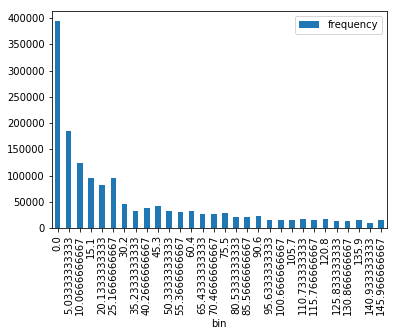

In [25]:
# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*hist_1_2)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

In [ ]:
hist_1_3 = app_users_1_2.select('myvf_last_navig_last151').rdd.flatMap(lambda x: x).histogram(20)

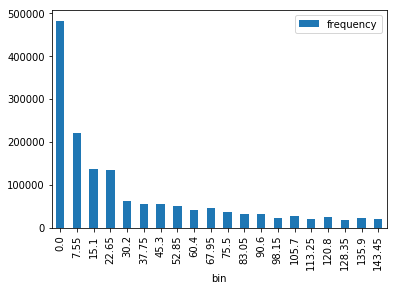

In [28]:
# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*hist_1_3)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

In [33]:
app_zoom_1_4=app_users_1_2.filter(col('myvf_last_navig_last151')<=30)

In [34]:
hist_1_4 = app_zoom_1_4.select('myvf_last_navig_last151').rdd.flatMap(lambda x: x).histogram(20)

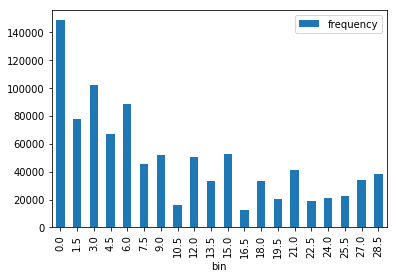

In [35]:
# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*hist_1_4)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

In [52]:
hist_1_4

([0.0,
  1.5,
  3.0,
  4.5,
  6.0,
  7.5,
  9.0,
  10.5,
  12.0,
  13.5,
  15.0,
  16.5,
  18.0,
  19.5,
  21.0,
  22.5,
  24.0,
  25.5,
  27.0,
  28.5,
  30],
 [148372,
  77492,
  101846,
  66710,
  88210,
  45396,
  51978,
  16219,
  50423,
  33122,
  52688,
  12842,
  33179,
  20643,
  41191,
  18693,
  21361,
  22270,
  33949,
  38451])

## Segmentación 2.2: nº de días diferentes que ha accedido a la app en los últimos 6 meses (para clientes que accedieron a la app antes de febrero)

In [20]:
hist2_2 = app_users_final.select('myvf_nb_days_access_last151').rdd.flatMap(lambda x: x).histogram(30)

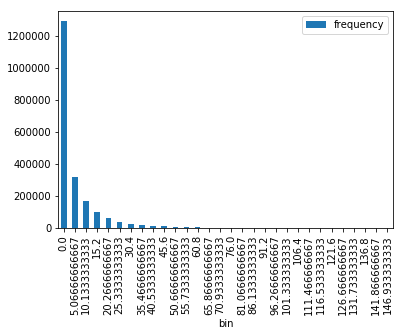

In [21]:
# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*hist2_2)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

In [22]:
hist2_3 = app_users_final.select('myvf_nb_days_access_last151').rdd.flatMap(lambda x: x).histogram(20)

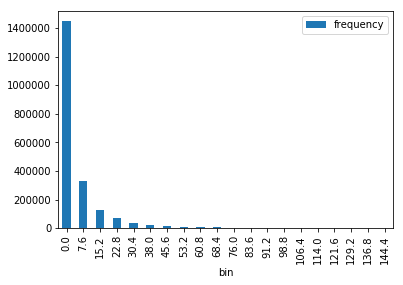

In [23]:
# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*hist2_3)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

In [29]:
app_zoom_2_4=app_users_final.filter(col('myvf_nb_days_access_last151')<=25)

In [31]:
hist2_4 = app_zoom_2_4.select('myvf_nb_days_access_last151').rdd.flatMap(lambda x: x).histogram(20)

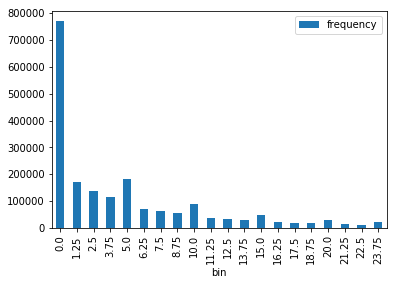

In [32]:
# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*hist2_4)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

## Segmentación 3: número de accesos a la app en los últimos 6 meses

In [40]:
hist3 = app_users_final.select('myvf_nb_pages_last151').rdd.flatMap(lambda x: x).histogram(30)

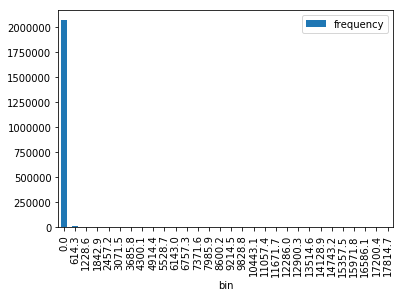

In [41]:
# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*hist3)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

In [43]:
app_zoom_3=app_users_final.filter(col('myvf_nb_pages_last151')<=1228.6)

In [44]:
hist3_2 = app_zoom_3.select('myvf_nb_pages_last151').rdd.flatMap(lambda x: x).histogram(20)

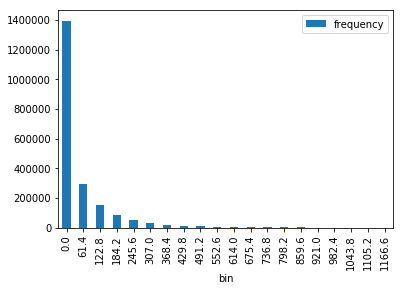

In [45]:
# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*hist3_2)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

In [46]:
app_zoom_3_1=app_users_final.filter(col('myvf_nb_pages_last151')<=614.3)

In [47]:
hist3_3 = app_zoom_3_1.select('myvf_nb_pages_last151').rdd.flatMap(lambda x: x).histogram(20)

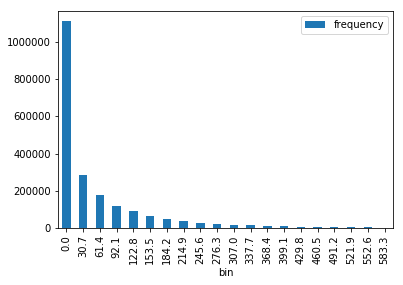

In [48]:
# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*hist3_3)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

In [49]:
app_zoom_3_2=app_users_final.filter(col('myvf_nb_pages_last151')<=30.7)

In [50]:
hist3_4 = app_zoom_3_2.select('myvf_nb_pages_last151').rdd.flatMap(lambda x: x).histogram(20)

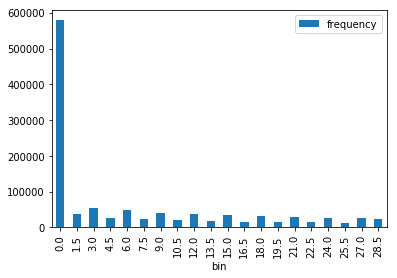

In [51]:
# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*hist3_4)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

In [54]:
x=spark.read.load('/data/udf/vf_es/amdocs_inf_dataset/amdocs_ids_service_level/v1.1.0/year=2020/month=7/day=14')

In [55]:
x.columns

['NIF_CLIENTE',
 'msisdn',
 'NUM_CLIENTE',
 'Instancia_P',
 'NUM_DIRECCION',
 'Cust_TRATAMIENTO',
 'Cust_CLASE_CLI_COD_CLASE_CLIENTE',
 'Cust_municipio',
 'Cust_COD_ESTADO_GENERAL',
 'Cust_municipio_factura',
 'Cust_provincia_factura',
 'Cust_METODO_PAGO',
 'Cust_PUBLICIDAD',
 'Cust_ENCUESTAS',
 'Cust_FACTURA_CATALAN',
 'Cust_FACTURA_ELECTRONICA',
 'Cust_SUPEROFERTA',
 'Cust_NIF_FACTURACION',
 'Cust_TIPO_DOCUMENTO',
 'Cust_X_PUBLICIDAD_EMAIL',
 'Cust_CICLO',
 'Cust_NACIONALIDAD',
 'Cust_x_tipo_cuenta_corp',
 'Cust_x_antiguedad_cuenta',
 'Cust_x_datos_navegacion',
 'Cust_x_datos_trafico',
 'Cust_x_cesion_datos',
 'Cust_x_user_facebook',
 'Cust_x_user_twitter',
 'Cust_civil_status',
 'Cust_gender',
 'Cust_birth_date',
 'Cust_FLG_LORTAD',
 'Cust_FLG_ROBINSON',
 'Cust_X_FORMATO_FACTURA',
 'Cust_X_IDIOMA_FACTURA',
 'Cust_FECHA_MIGRACION',
 'Cust_ENCUESTAS2',
 'Cust_cta_correo_flag',
 'Cust_age',
 'Cust_CODIGO_POSTAL',
 'Cust_provincia',
 'Cust_L2_codigo_postal_city',
 'Cust_L2_days_until_ne